In [1]:
# Standard stuff
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import norm


import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

# # ML stuff
from keras.layers import Dense, Dropout, Input, Concatenate, LeakyReLU
import tensorflow as tf
from GaussianAnsatz.utils import build_gaussianAnsatz_DNN, build_gaussianAnsatz_EFN, build_gaussianAnsatz_PFN, determine_constant
import energyflow as ef

# # Extra utils
# from JEC.JEC_utils import load_data
# from GaussianAnsatz.utils import plot_MI

2023-07-10 17:39:47.568663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-10 17:39:47.568702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
y_dim = 1
x_dim = 3
loadfile = None
dnn_loadfile = "Models/DNN.hdf5"
efn_loadfile = "Models/EFN.hdf5"
pfn_loadfile = "Models/PFN.hdf5"
pfn_pid_loadfile = "Models/PFN_PID.hdf5"
cache_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"

colors = ['red', 'yellow', 'green', 'blue', "purple"]
labels = ['DNN', "EFN", "PFN", "PFN-PID", "CMS"]

# Dataset Parameters
momentum_scale = 1000
n = 2500
pad = 150
pad_EFN = 150
pad_PFN = 150
pt_lower, pt_upper = 695, 705
eta = 2.4
quality = 2
epochs = 150
d_multiplier = 0.0

-0.12193766448967835 567.0523952604486 567.1133240297905
7.511590314975251 714.6914308876798 710.9062102668116
-1.025038458138397 712.2995850639444 712.8113524907762
0.48194479397147916 689.9349803944335 689.6939674821458
-4.406949564512956 716.0905781905483 718.2827898012157
0.9553223033343556 624.2064555336585 623.7284478286958
-9.984924062563323 697.1898808242163 702.1256576869013
-4.492727248668643 677.5756500586109 679.8097556895597
-8.335689572813976 667.2443025257467 671.3708734665942
3.7796127923443237 697.9029899003935 696.0059522977472
3.7477797307453784 719.0282382502234 717.1474001904552
7.3513417235856195 732.2664041835928 728.5631111559811
-3.7503481568705865 682.9175774652261 684.7841471432732
-5.593714845694876 686.6214554794258 689.3997923885341
5.351107569778037 711.2321341688275 708.5418815548215
6.309217113814043 680.9512393299451 677.7752796353585
2.674105200252484 680.8294660679977 679.4888771134274
-2.938143020697794 700.0403066685179 701.5040918899741
-5.3955972

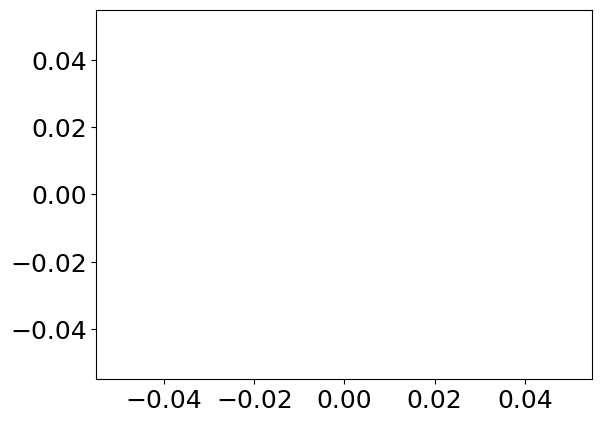

In [12]:
Lambda = 1

specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f' abs_jet_eta < {eta}', f' quality >= {quality}']
sim = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='sim',subdatasets=["SIM1000_Jet300_pT375-infGeV"])
# gen = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='gen',subdatasets=["GEN1000_pT375-infGeV"])

sim14 = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='sim',subdatasets=["SIM1400_Jet300_pT375-infGeV"])
sim18 = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='sim',subdatasets=["SIM1800_Jet300_pT375-infGeV"])

# gen14 = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='gen',subdatasets=["GEN1400_pT375-infGeV"])
# gen18 = ef.mod.load(*specs, cache_dir =  cache_dir, dataset='gen',subdatasets=["GEN1800_pT375-infGeV"])



simjets_f = sim.jets_f[0:20000]
sim14jets_f = sim14.jets_f[0:20000]
sim18jets_f = sim18.jets_f[0:20000]








#mjjjets_f

simjets = np.concatenate([sim.jets_f,sim14.jets_f,sim18.jets_f])

mjjs = []
mjjs_C = []
mjjs_C_improved = []


mjjsg = []
weights = []
pTs = []
pTsg = []
etas = []
etasg = []


def calculate_JJ(arr, calibrate = False, improved = False):


    pT1 = simjets[2*i,0] if not calibrate else simjets[2*i,0] * simjets[2*i,5]
    pT2 = simjets[2*i+1,0] if not calibrate else simjets[2*i,0] * simjets[2*i+1,5]
    
    y1 = simjets[2*i,1]
    y2 = simjets[2*i+1,1]
    
    phi1 = simjets[2*i,2]
    phi2 = simjets[2*i+1,2]
    
    m1 = simjets[2*i,3] if not calibrate else simjets[2*i,3] * simjets[2*i,5]
    m2 = simjets[2*i+1,3] if not calibrate else simjets[2*i,3] * simjets[2*i+1,5]

    if calibrate and improved:


        # pt 
        res1 = pT1 * np.sqrt( 30/pT1**2 + 0.81/pT1 + 0.04**2   )
        res2 = pT2 * np.sqrt( 30/pT2**2 + 0.81/pT2 + 0.04**2   )


        var = np.sqrt(Lambda**2 + res1**2 + res2**2)
        p1hathat = (pT1 * Lambda**2 + pT1 * res2**2 + pT2 * res1**2) / var**2
        p2hathat = (pT2 * Lambda**2 + pT1 * res2**2 + pT2 * res1**2) / var**2

        print(pT1 - pT2, pT1, p1hathat)
        pT1 = p1hathat
        pT2 = p2hathat

        # m 
        res1 = m1 * np.sqrt( 30/pT1**2 + 0.81/pT1 + 0.04**2   )
        res2 = m2 * np.sqrt( 30/pT2**2 + 0.81/pT2 + 0.04**2   )


        var = np.sqrt(Lambda**2 + res1**2 + res2**2)
        p1hathat = (m1 * Lambda**2 + m1 * res2**2 + m2 * res1**2) / var**2
        p2hathat = (m2 * Lambda**2 + m1 * res2**2 + m2 * res1**2) / var**2

        m1 = p1hathat
        m2 = p2hathat

    
    ET1 = np.sqrt(pT1**2+m1**2)
    ET2 = np.sqrt(pT2**2+m2**2)


    mJJ = m1**2+m2**2+2*(ET1*ET2*np.cosh(y1-y2)-pT1*pT2*np.cos(phi1-phi2))

    if not calibrate:

        arr+=[mJJ**0.5]
        arr+=[mJJ**0.5]



    else:
        arr+=[mJJ**0.5]
        arr+=[mJJ**0.5]



for i in range(int(len(simjets)/2.)):
    
    #Truth
    pT1g = simjets[2*i,8]
    pT2g = simjets[2*i+1,8]
    
    y1g = simjets[2*i,9]
    y2g = simjets[2*i+1,9]
    
    phi1g = simjets[2*i,10]
    phi2g = simjets[2*i+1,10]
    
    m1g = simjets[2*i,11]
    m2g = simjets[2*i+1,11]

    
    ET1g = np.sqrt(pT1g**2+m1g**2)
    ET2g = np.sqrt(pT2g**2+m2g**2)
    
    mJJg = m1g**2+m2g**2+2*(ET1g*ET2g*np.cosh(y1g-y2g)-pT1g*pT2g*np.cos(phi1g-phi2g))
    mjjsg+=[mJJg**0.5]
    mjjsg+=[mJJg**0.5]
    pTsg+=[pT1g]
    pTsg+=[pT2g]
    etasg+=[y1g]
    etasg+=[y2g]
    
    #Reco
    calculate_JJ(mjjs, calibrate=False)
    calculate_JJ(mjjs_C, calibrate=True)
    calculate_JJ(mjjs_C_improved, calibrate=True, improved=True)


    pTs+=[pT1g]
    pTs+=[pT2g]
   
    
    weights+=[simjets[2*i,-1]]
    weights+=[simjets[2*i,-1]]


#Divide in half
inds1 = np.random.choice(range(len(mjjs)), size=(int(0.5*len(mjjs)),), replace=False)
inds2 = list(set(range(len(inds1))) - set(inds1))

mjjs = np.array(mjjs)
mjjsg = np.array(mjjsg)
weights = np.array(weights)
mjjs_firsthalf = mjjs[inds1]
mjjs_secondhalf = mjjs[inds2]
mjjsg_firsthalf = mjjsg[inds1]
mjjsg_secondhalf = mjjsg[inds2]
weights_firsthalf = weights[inds1]
weights_secondhalf = weights[inds2]


# Reweight 
lower_lim = 1750
bins = 50

resonance_mass = 2800
resonance_width = 10
weights_bsm = norm.pdf(mjjsg, resonance_mass, resonance_width)

# plt.hist(mjjs_C_improved)
plt.hist(mjjs_C_improved, weights_bsm)
plt.savefig("test.jpg")


[<matplotlib.patches.Polygon object at 0x14756d1b3790>, <matplotlib.patches.Polygon object at 0x14756d1bb790>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] ['QCD Truth', 'BSM Truth', 'QCD Geant', 'QCD + CMS-JEC', 'QCD + Corr. Improved CMS-JEC', 'BSM Geant', 'BSM + CMS-JEC', 'BSM + Corr. Improved CMS-JEC']


/tmp/ipykernel_1580143/2223128726.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("test.jpg", transparency = False)


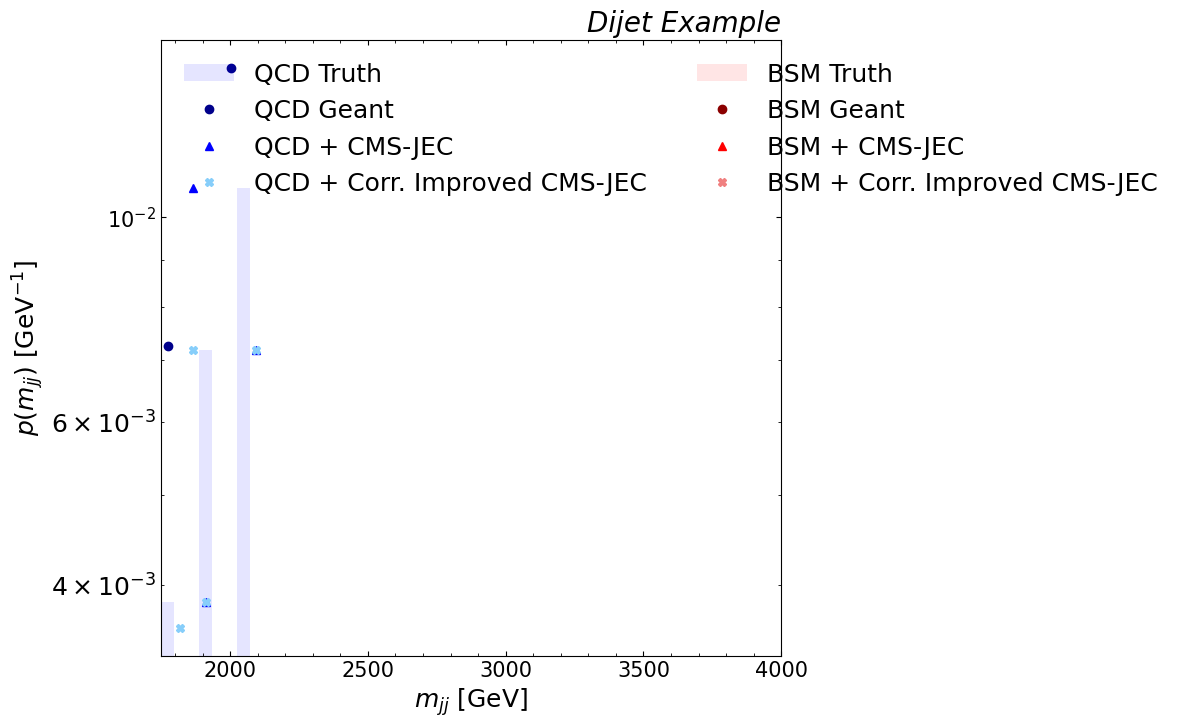

In [10]:



fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(hspace = .001)
plt.rcParams['font.size'] = '18'


ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax0.minorticks_on()



def hist_to_points(dist, weights, fmt, color, label):

    bin_counts, bin_edges, patches = plt.hist(dist,weights=weights,histtype="step",color="red",bins=np.linspace(lower_lim,4000,bins), density = True, alpha = 0)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.errorbar(x = bin_centers, y = bin_counts, fmt = fmt, color = color, label = label)



hist_to_points(mjjs, weights= weights, fmt = "o", color = "darkblue", label = "QCD Geant")
hist_to_points(mjjs_C, weights= weights, fmt = "^", color = "blue", label = "QCD + CMS-JEC")
hist_to_points(mjjs_C_improved, weights= weights, fmt = "X", color = "lightskyblue", label = "QCD + Corr. Improved CMS-JEC")
plt.hist(mjjsg, weights= weights, bins=np.linspace(1750,4000,50), color = "blue", alpha = .1, histtype = "stepfilled", label = "QCD Truth", density= True )


hist_to_points(mjjs, weights= weights_bsm, fmt = "o", color = "darkred", label = "BSM Geant")
hist_to_points(mjjs_C, weights= weights_bsm, fmt = "^", color = "red", label = "BSM + CMS-JEC")
hist_to_points(mjjs_C_improved, weights= weights_bsm, fmt = "X", color = "lightcoral", label = "BSM + Corr. Improved CMS-JEC")
plt.hist(mjjsg, weights= weights_bsm, bins=np.linspace(1750,4000,50), color = "red", alpha = .1, histtype = "stepfilled", label = "BSM Truth", density= True )


plt.legend(frameon = False)

# plt.ylim(1e-5, 1e-1)
plt.xlim(1750, 4000)
plt.yscale("log")
plt.xlabel("$m_{jj}$ [GeV]")
plt.ylabel("$p(m_{jj})$ [GeV$^{-1}$]")

plt.title("Dijet Example", fontsize = 20, fontstyle = "italic", loc = "right")

handles, labels = plt.gca().get_legend_handles_labels()
print(handles, labels)
order = [0, 2, 3, 4,  1, 5, 6, 7]
plt.legend([handles[i] for i in order], [labels[i] for i in order],frameon = False, loc = "upper left", ncol = 2)
plt.savefig("test.jpg", transparency = False)



In [5]:
# ############################
# ########## MODELS ##########
# ############################
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():
opt = tf.keras.optimizers.Adam()
DNN = build_gaussianAnsatz_DNN(x_dim, y_dim, [64, 64, 64], opt = opt)
EFN = build_gaussianAnsatz_EFN(x_dim, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(), pad_EFN, loadfile = efn_loadfile, d_multiplier = d_multiplier, opt = opt)
PFN = build_gaussianAnsatz_PFN(x_dim, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(),loadfile = pfn_loadfile, d_multiplier = d_multiplier, opt = opt)
PFN_pid = build_gaussianAnsatz_PFN(x_dim + 1, y_dim, (100, 100, 128, ), (100, 100, 100, ), LeakyReLU(), loadfile = pfn_pid_loadfile, d_multiplier = d_multiplier, opt = opt)

# DNN loading is weird:
DNN.pre_train([X_test[:100],Y_test[:100]], epochs = 1, batch_size= 2, verbose = False)
DNN.load_weights(dnn_loadfile)


def dnn_predict(test, model, c = 0):

    yhat, sigma, T, MI = DNN.eval(test[0], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def efn_predict(test, model, c = 0):
    yhat, sigma, T, MI = EFN.eval(test[1][:,:,:3], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def pfn_predict(test, model, c = 0):
    yhat, sigma, T, MI = model.eval(test[1][:,:,:3], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def pfn_pid_predict(test, model, c = 0):

    yhat, sigma, T, MI = model.eval(test[1], test[2], loss = joint, c = c)
    return yhat * momentum_scale, sigma * momentum_scale, T, MI

def cms_predict(test, model, c = 0):
    x = test[0]
    pt = x[:,0]
    yhat = momentum_scale * np.multiply(pt, test[3])
    jer = np.sqrt( 30/yhat**2 + 0.81/yhat + 0.04**2   )
    return yhat, np.multiply(yhat, jer), np.zeros_like(yhat), 0.0

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 100)   300         ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['time_distributed[0][0]',       
                                                                  'time_distributed_1[0][0]',     
                                                                  'time_distributed_2[0][0]', 

2023-07-10 17:41:42.447317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-10 17:41:42.447356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-10 17:41:42.447382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (boslogin02.rc.fas.harvard.edu): /proc/driver/nvidia/version does not exist
2023-07-10 17:41:42.448082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 time_distributed_3 (TimeDistri  (None, None, 100)   300         ['input_4[0][0]']                
 buted)                                                                                           
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['time_distributed_3[0][0]',     
                                                                  'time_distributed_4[0][0]',     
                                                                  'time_distributed_5[0][0]'

NameError: name 'X_test' is not defined

In [ ]:
# from GaussianAnsatz.utils import plot_MI

# # Mutual Information plots
# names = ["DNN", "EFN", "PFN", "PFN_PID"]


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)
# plt.rcParams['font.size'] = '18'


# for (i, name) in enumerate(names):


#     MI = np.load("Models/%s.npy" % name)
#     plot_MI(600, MI, "_", [200, 400], color = colors[i], label = name, savefig = False)


# plt.xlabel("Epochs")
# plt.ylabel("I(X;Y)")
# plt.title("Learned Mutual Information")
# plt.legend()
# # plt.savefig("JEC/Plots/MI.pdf")
# plt.show()

In [ ]:
# ##### PT Plots #####

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'


# Make predictions
predictions = np.array((dnn_predict(test, DNN), efn_predict(test, EFN), pfn_predict(test, PFN), pfn_pid_predict(test, PFN_pid), cms_predict(test, None)))

# P_t distribution histograms
for i in range(4):
    mean, std = np.mean(predictions[i,0]), np.std(predictions[i,0])
    plt.hist(predictions[i,0], bins=25, range=[550,850], histtype = 'step', color = colors[i], label = r'$\hat{y}_{%s}$; %0.1f$\pm$%0.1f GeV' % (labels[i], mean, std), density=True)
    

    # Gaussian Fit
    temp = predictions[i,0][predictions[i,0] < 850]
    temp = predictions[i,0][predictions[i,0] > 550]
    x = np.linspace(550, 850, 100)
    fit = norm.pdf(x, *(norm.fit(temp)))
    plt.plot(x,fit, color = colors[i] ,label = r"%s Fit; %0.1f $\pm$ %0.1f" % (labels[i], *norm.fit(temp) )  )  

plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")
plt.grid()
plt.legend()
plt.close()

In [ ]:
# ##### UNCERTAINTY PLOTS #####

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'


# P_t uncertainty distribution histograms
for i in range(predictions.shape[0]):
    mean, std = np.mean(predictions[i,1]), np.std(predictions[i,1])
    plt.hist(predictions[i,1], bins=100, range=[15,50], histtype = 'stepfilled', alpha = 0.25, color = colors[i], label = r'$\sigma_{%s}$; %0.1f$\pm$%0.1f GeV' % (labels[i], mean, std), density=True)
    plt.hist(predictions[i,1], bins=100, range=[15,50], histtype = 'step', color = colors[i], density=True)

plt.xlabel(r"$\sigma_{p_T}$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")
# plt.grid()
plt.legend(loc = "upper left")
plt.savefig("Resolutions.pdf")
plt.show()

In [ ]:
# Dijet Loader

import energyflow as ef
from energyflow.utils import remap_pids

def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0, return_pfcs = True):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_gen_jet_eta < {eta}', f'quality >= {quality}']
    # specs = [f'{pt_lower} <= jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount, store_gens = False)

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    event_ids = np.zeros((Y1.shape[0],1), dtype = np.int32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    event_ids = sim.jets_i[:,sim.evn]



    # CMS JEC's
    C = sim.jets_f[:,sim.jec]

    # PFC's
    pfcs = sim.particles


    pfcs = pfcs[:n]
    Y = Y[:n]
    X = X[:n]
    C = C[:n]
    event_ids = event_ids[:n]

    # PFC's
    dataset = np.zeros( (pfcs.shape[0], pad, x_dim), dtype = np.float32 )
    particle_counts = []
    if return_pfcs:
        for (i, jet) in enumerate(pfcs):
            size = min(jet.shape[0], pad)
            indices = (-jet[:,0]).argsort()
            dataset[i, :size, 0] = jet[indices[:size],0] / momentum_scale
            dataset[i, :size, 1] = jet[indices[:size],1]
            dataset[i, :size, 2] = jet[indices[:size],2]
            if x_dim == 4:
                dataset[i, :size, 3] = jet[indices[:size],4] # PID
            particle_counts.append(jet.shape[0])
        if x_dim == 4:
            remap_pids(dataset, pid_i = 3, error_on_unknown = False)

        for x in dataset:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  

    particle_counts = np.array(particle_counts)

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]
        C = C[particle_counts < max_particle_select]
        particle_counts = particle_counts[particle_counts < max_particle_select]


    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)
    print("PFCs: ", dataset.shape, dataset.dtype)

    if not return_pfcs:
        return X, Y, C, particle_counts, event_ids
   
    print("Max # of particles: %d" % max(particle_counts))
    return X, dataset, Y, C, particle_counts, event_ids



y_dim = 1
x_dim = 3



# Dataset Parameters
cache_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"
momentum_scale = 1000
n = 10000
pad = 150
pt_lower, pt_upper = 695, 705
eta = 2.4
quality = 2

# #############################
# ########## DATASET ##########
# #############################

X, pfcs, Y, C, N, ids = load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, momentum_scale = momentum_scale, n = n, max_particle_select = None, amount = 1, return_pfcs= True)


sorted = np.sort(ids)
sorted_indices = ids.argsort()
print(ids.shape)
print(sorted)


counter = 0
pairs = []
N = len(sorted)
for (i,id) in enumerate(sorted):
    for (j, id2) in enumerate(sorted[(i+1):]):

        if id == id2:
            counter += 1
            pairs.append((i, i+1+j))
            break

        if id2 > id:
            break

print(counter / N )

In [ ]:
sorted_gen_pts = Y[sorted_indices]
sorted_Xs = X[sorted_indices]
sorted_Cs = C[sorted_indices]
sorted_pfcs =  pfcs[sorted_indices]

leading_gen_pts = []
subleading_gen_pts = []
leading_sim_pts = []
subleading_sim_pts = []
leading_Cs = []
subleading_Cs = []
leading_pfcs = []
subleading_pfcs = []

for pair in pairs:

    jet1 = sorted_gen_pts[pair[0]]
    jet2 = sorted_gen_pts[pair[1]]

    sim_jet1 = sorted_Xs[pair[0]]
    sim_jet2 = sorted_Xs[pair[1]]


    if jet1 > jet2:
        leading_gen_pts.append(jet1)
        subleading_gen_pts.append(jet2)

        leading_sim_pts.append(sim_jet1)
        subleading_sim_pts.append(sim_jet2)
        leading_Cs.append(sorted_Cs[pair[0]])
        subleading_Cs.append(sorted_Cs[pair[1]])
        leading_pfcs.append(sorted_pfcs[pair[0]])
        subleading_pfcs.append(sorted_pfcs[pair[1]])
    else:
        leading_gen_pts.append(jet2)
        subleading_gen_pts.append(jet1)

        leading_sim_pts.append(sim_jet2)
        subleading_sim_pts.append(sim_jet1)
        leading_Cs.append(sorted_Cs[pair[1]])
        subleading_Cs.append(sorted_Cs[pair[0]])
        leading_pfcs.append(sorted_pfcs[pair[1]])
        subleading_pfcs.append(sorted_pfcs[pair[0]])

leading_gen_pts = np.array(leading_gen_pts)
subleading_gen_pts = np.array(subleading_gen_pts)

leading_sim_pts = np.array(leading_sim_pts)
subleading_sim_pts = np.array(subleading_sim_pts)
leading_Cs =np.array(leading_Cs)
subleading_Cs=np.array(subleading_Cs)
leading_pfcs =np.array(leading_pfcs)
subleading_pfcs=np.array(subleading_pfcs)

leadings = [leading_sim_pts, leading_pfcs, leading_pfcs]
subleadings =[subleading_sim_pts, subleading_pfcs, subleading_pfcs]


In [ ]:
   


Lambda = 22.3 / momentum_scale

# CMS Result
leading_predicts = leading_sim_pts[:,0] * leading_Cs
subleading_predicts = subleading_sim_pts[:,0] * subleading_Cs


detector_jet1 = np.copy(leading_predicts)
detector_jet2 = np.copy(subleading_predicts)
res1 = 1.06*leading_predicts * np.sqrt( 30/(momentum_scale * leading_predicts)**2 + 0.81/(momentum_scale * leading_predicts) + 0.04**2   ) 
res2 = 1.06*subleading_predicts * np.sqrt( 30/(momentum_scale * subleading_predicts)**2 + 0.81/(momentum_scale * subleading_predicts) + 0.04**2   ) 

# Math
var = np.sqrt(Lambda**2 + res1**2 + res2**2)
p1hathat = (detector_jet1 * Lambda**2 + detector_jet1 * res2**2 - detector_jet2 * res1**2) / var**2
p2hathat = (detector_jet2 * Lambda**2 - detector_jet1 * res2**2 + detector_jet2 * res1**2) / var**2

var1hathat = np.sqrt(1/(1/Lambda**2 + 1/res1**2))
var2hathat = np.sqrt(1/(1/Lambda**2 + 1/res2**2))


ptothathat = p1hathat + p2hathat
vartothathat = np.sqrt(var1hathat**2 + var2hathat**2)


concat_stds = momentum_scale * np.concatenate((res1, res2), axis = 0)
concat_stds_corrected = momentum_scale * np.concatenate((var1hathat,var2hathat), axis = 0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = '18'

plt.hist(concat_stds, bins = 100, range = [15,50], label = "CMS", color = "purple", alpha = 0.5, density = True)
plt.hist(concat_stds_corrected, bins = 100, range = [15,50], label = "CMS Corr-Imp.", color = "purple", alpha = 0.5, histtype ="step", density = True)



print(np.mean(concat_stds))


for (i,model) in enumerate([DNN,EFN, PFN]):
    detector_jet1, res1 = model.eval(leadings[i])
    detector_jet2, res2 = model.eval(subleadings[i])


    detector_jet1 = leading_predicts
    detector_jet2 = subleading_predicts
    # res1 = leading_stds
    # res2 = subleading_stds

    # Math
    var = np.sqrt(Lambda**2 + res1**2 + res2**2)
    p1hathat = (detector_jet1 * Lambda**2 + detector_jet1 * res2**2 - detector_jet2 * res1**2) / var**2
    p2hathat = (detector_jet2 * Lambda**2 - detector_jet1 * res2**2 + detector_jet2 * res1**2) / var**2

    var1hathat = np.sqrt(1/(1/Lambda**2 + 1/res1**2))
    var2hathat = np.sqrt(1/(1/Lambda**2 + 1/res2**2))


    ptothathat = p1hathat + p2hathat
    vartothathat = np.sqrt(var1hathat**2 + var2hathat**2)


    concat_stds = momentum_scale  * np.concatenate((res1, res2), axis = 0)
    concat_stds_corrected = momentum_scale * np.concatenate((var1hathat,var2hathat), axis = 0)

    plt.hist(concat_stds, bins = 100, range = [15,50], label = "GA %s" % labels[i], color = colors[i], alpha = 0.5, density = True)
    plt.hist(concat_stds_corrected, bins = 100, range = [15,50], label = "GA %s Corr-Imp." % labels[i], color = colors[i], alpha = 0.5, histtype ="step", density = True, lw = 3)


plt.legend(title = "$\Lambda = %.1f$ GeV" % (Lambda * 1000))
plt.xlabel(r"$\sigma_{p_T}$ [GeV]")
plt.ylabel("Density")
plt.title(r"Distributions for Gen $p_T \in [695, 705]$ GeV")

plt.savefig("Correlation_Improved_Resolutions.pdf")


# Dijet Mass

In [ ]:
# Load in GEANT4 test set


def load_data(cache_dir, pt_lower, pt_upper, eta, quality, pad, x_dim = 3, momentum_scale = 250, n = 100000, amount = 1, max_particle_select = None, frac = 1.0, return_pfcs = True):

    # Load data
    specs = [f'{pt_lower} <= gen_jet_pts <= {pt_upper}', f'abs_jet_eta < {eta}', f'quality >= {quality}']
    sim = ef.mod.load(*specs, cache_dir = cache_dir, dataset='sim', amount= amount)

    # Gen_pt for Y
    Y1 = sim.jets_f[:,sim.gen_jet_pt]
    Y = np.zeros((Y1.shape[0], 1), dtype = np.float32 )
    Y[:,0] = Y1 / momentum_scale

    # Sim_pt for X
    X = np.zeros((Y1.shape[0],3), dtype = np.float32)
    X[:,0] = sim.jets_f[:,sim.jet_pt] / momentum_scale
    X[:,1] = sim.jets_f[:,sim.jet_eta]
    X[:,2] = sim.jets_f[:,sim.jet_phi]
    X[:,3] = sim.jets_f[:,sim.jet_m] / momentum_scale



    # CMS JEC's
    C = sim.jets_f[:,sim.jec]

    # PFC's
    pfcs = sim.particles

    # Shuffle and trim
    shuffle_indices = np.random.choice(np.arange(pfcs.shape[0]), size = int(pfcs.shape[0] * frac), replace=False)
    pfcs = pfcs[shuffle_indices]
    Y = Y[shuffle_indices]
    X = X[shuffle_indices]
    C = C[shuffle_indices]

    pfcs = pfcs[:n]
    Y = Y[:n]
    X = X[:n]
    C = C[:n]

    # PFC's
    dataset = np.zeros( (pfcs.shape[0], pad, x_dim), dtype = np.float32 )
    particle_counts = []
    if return_pfcs:
        for (i, jet) in enumerate(pfcs):
            size = min(jet.shape[0], pad)
            indices = (-jet[:,0]).argsort()
            dataset[i, :size, 0] = jet[indices[:size],0] / momentum_scale
            dataset[i, :size, 1] = jet[indices[:size],1]
            dataset[i, :size, 2] = jet[indices[:size],2]
            if x_dim == 4:
                dataset[i, :size, 3] = jet[indices[:size],4] # PID
            particle_counts.append(jet.shape[0])
        if x_dim == 4:
            remap_pids(dataset, pid_i = 3, error_on_unknown = False)

        for x in dataset:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  

    particle_counts = np.array(particle_counts)

    # Trim and shuffle
    if max_particle_select is not None:
        dataset = dataset[particle_counts < max_particle_select]
        Y = Y[particle_counts < max_particle_select]
        X = X[particle_counts < max_particle_select]
        C = C[particle_counts < max_particle_select]
        particle_counts = particle_counts[particle_counts < max_particle_select]

    shuffle_indices = np.random.choice(np.arange(dataset.shape[0]), size = int(dataset.shape[0] * frac), replace=False)

    print("X: ", X.shape, X.dtype)
    print("Y: ", Y.shape, Y.dtype)
    print("PFCs: ", dataset.shape, dataset.dtype)

    if not return_pfcs:
        return X, Y, C, particle_counts
   
    print("Max # of particles: %d" % max(particle_counts))
    return X, dataset, Y, C, particle_counts



sim10 = ef.mod.load(dataset='sim',subdatasets=["SIM1000_Jet300_pT375-infGeV"])
gen10 = ef.mod.load(dataset='gen',subdatasets=["GEN1000_pT375-infGeV"])

sim14 = ef.mod.load(dataset='sim',subdatasets=["SIM1400_Jet300_pT375-infGeV"])
sim18 = ef.mod.load(dataset='sim',subdatasets=["SIM1800_Jet300_pT375-infGeV"])

gen14 = ef.mod.load(dataset='gen',subdatasets=["GEN1400_pT375-infGeV"])
gen18 = ef.mod.load(dataset='gen',subdatasets=["GEN1800_pT375-infGeV"])





In [ ]:





# TOOD: Convert Ben's code to my code.

#Truth
    pT1g = simjets[2*i,8]
    pT2g = simjets[2*i+1,8]
    
    y1g = simjets[2*i,9]
    y2g = simjets[2*i+1,9]
    
    phi1g = simjets[2*i,10]
    phi2g = simjets[2*i+1,10]
    
    m1g = simjets[2*i,11]
    m2g = simjets[2*i+1,11]
    
    ET1g = np.sqrt(pT1g**2+m1g**2)
    ET2g = np.sqrt(pT2g**2+m2g**2)
    
    mJJg = m1g**2+m2g**2+2*(ET1g*ET2g*np.cosh(y1g-y2g)-pT1g*pT2g*np.cos(phi1g-phi2g))
    mjjsg+=[mJJg**0.5]
    mjjsg+=[mJJg**0.5]
    pTsg+=[pT1g]
    pTsg+=[pT2g]
    etasg+=[y1g]
    etasg+=[y2g]